## Part 0: Preliminaries

### Part 0.1: imports & constants

In [26]:
#library dependencies
import numpy as np
import music21 as m21
import pretty_midi as pm
import drawSvg as draw

import tempfile
import math
import os
import matplotlib.pyplot as plt

#for fast dirty plotting
from matplotlib.pyplot import imshow
from scipy.misc import toimage
from PIL import Image, ImageOps
from IPython.display import display


test_midi_folder = 'midiFiles/'

### Part 0.2: Test functions

In [9]:
def test(assertion, test_name, test_logger):
    test_logger[test_name] = assertion

def test_bilan(test_logger):
    all_good = True
    failed_tests = [k for k,v in test_logger.items() if not v]
    test_nmbr = len(test_logger.items())
    if len(failed_tests) > 0:
        print("%d out of %d tests failed. The failed tests are: "%(len(failed_tests), test_nmbr))
        for s in failed_tests:
            print(s)
    else:
        print("All %d tests succeeded."%test_nmbr)

# Part 1: file to list of PCVs 

## Part 1.1 code

In [10]:
twelve_tones_vector_name = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#','A', 'A#', 'B']

altered_notation_dict = {
    'B#' : 'C',
    'D-' : 'C#',
    'E-' : 'D#',
    'F-' : 'E',
    'E#' : 'F',
    'G-' : 'F#',
    'A-' : 'G#',
    'B-' : 'A#',
    'C-' : 'B'
} 

pitch_pitch_dict = {x: x for x in twelve_tones_vector_name}

#In the end we want each string to match an index between 0 and 11, so it fits inside a 12-d vector.
pitch_index_dict = {twelve_tones_vector_name[i]:i for i in range(len(twelve_tones_vector_name))}

#So any pitch name given to this dict will be mapped to its cannonical form defined in 'twelve_tones_vector_name'
normalize_notation_dict = dict(altered_notation_dict,  **pitch_pitch_dict)

def recursively_map_offset(filename, only_note_name=True):
    '''
    This function will recursively walk through the Midi stream's elements, 
    and whenever it encounters a note, it will append its rhytmic 
    data to the pitch and then store the resulting data structure in an array.
    If a music21 element of type chord is encountered, the chord is decomposed into all
    notes it is composed by, and each of thoses notes are appended the 
    Returns the aforementionned array.
    The rhytmic data is expressed as a tuple of the offset of the beginning of the note
    and the offset of the end of the note.
    
    All temporal informations from MIDI events parsed by the music21 library are encoded
    as unit of quarter notes count, regardless of the bpm or the time signature.
    
    Params: 
    midi stream: the MIDI stream containing all the relevant infos
    flatten: Boolean, indicating whether or not the chords elements 
            need to be flattened into singles notes.
    only_note_name: Boolean, indicating whether the notes need to be 
                    converted from music21 object with octave indication
                    to only a string indicating the pitch.
    '''
    midi_stream = m21.converter.parse(filename)
    res = []
    for elem in midi_stream.recurse():
        if isinstance(elem, m21.note.Note):
            start_offset = elem.getOffsetInHierarchy(midi_stream)
            res.append((elem.name if only_note_name else elem, (start_offset, start_offset+elem.duration.quarterLength)))
        elif isinstance(elem, m21.chord.Chord):
            start_offset = elem.getOffsetInHierarchy(midi_stream)
            res += list(map(lambda r: (r.name if only_note_name else r , (start_offset, start_offset+elem.duration.quarterLength)), elem.pitches))
    return res


def remove_drums_from_midi_file(midi_filename):
    '''
    Takes care of removing drum tracks from a midi filename.
    Work only if the MIDI file has metadata clearly indicating channels that are
    percussive. Does not remove channels of percussive instruments that are pitched
    (like the glockenspiel for instance).  
    
    Param: 
    midi_filename:= the filename of the MIDI file that needs to be removed from drum tracks. 
    
    returns:
    The (temporary) filepath of the midi file generated without the drum channel.
    
    '''
    sound = pm.PrettyMIDI(midi_filename)
    
    #getting the track indices of unpitched "percussive" tracks. 
    drum_instruments_index = [idx for idx, instrument in enumerate(sound.instruments) if instrument.is_drum]
    for i in sorted(drum_instruments_index, reverse=True):
        del sound.instruments[i]

    folder = tempfile.TemporaryDirectory()
    temp_midi_filepath = folder.name+'tmp.mid'
    sound.write(temp_midi_filepath)
    
    return temp_midi_filepath

def only_keep_pitches_in_boundaries(pitch_offset_list, beat1_offset, beat2_offset): 
    return list(filter(lambda n: n[1][1] >= beat1_offset and n[1][0] <= beat2_offset, pitch_offset_list))


def slice_according_to_beat(pitch_offset_list, beat1_offset, beat2_offset):
    #the beat offset must be expressed as relation of quarter note. 
    #Taken are all beat which at least END AFTER the beat1, and START BEFORE the beat2
    res = []
    if beat1_offset >= beat2_offset:
        return res
    for n in only_keep_pitches_in_boundaries(pitch_offset_list, beat1_offset, beat2_offset):
        start_b = n[1][0]
        end_b = n[1][1]
        
        res_n = None
        if start_b >= beat1_offset:
            if end_b > beat2_offset:
                res_n = (n[0], (start_b, beat2_offset))
            else:
                res_n = (n[0], (start_b, end_b))
        elif end_b <= beat2_offset:
            #if start_b < beat1_offset: #of course we are in this case since the first if was not triggered.
            res_n = (n[0], (beat1_offset, end_b))
        else:
            #we are thus in the case the start and end time of the note overshoot the boundaries.
            res_n = (n[0], (beat1_offset, beat2_offset))
        #normally inconsistent results should not happen, but it is possible to have a note with duration equals to 0. This line below prevents that and thus keep the things concise.
        if res_n[1][0] < res_n[1][1]:
            res.append(res_n)
    return res

def sum_into_pitch_class_vector(pitch_offset_list, start_beat, end_beat):
    pitch_class_offset = lambda t: pitch_index_dict[normalize_notation_dict[t[0]]]
    pitch_class_vec = np.zeros(12)
    for tup in pitch_offset_list:
        #we need to be sure we don't take into account the part of the note that exceed the window's size.
        min_beat = max(start_beat, tup[1][0])
        max_beat = min(end_beat, tup[1][1])
        pitch_weight = max_beat - min_beat
        pitch_class_vec[pitch_class_offset(tup)] += pitch_weight
    return pitch_class_vec


def get_max_beat(pitch_offset_list):
    return math.ceil(max(list(map(lambda r: r[1][1], pitch_offset_list))))

def pitch_class_set_vector_from_pitch_offset_list(pitch_offset_array, aw_size=0.5): #the analysis window size (aw_size) is expressed in terms of number of quarter.
    
    
    max_beat = get_max_beat(pitch_offset_array)
    
    if aw_size <= max_beat/2:
        chunk_number = math.ceil(max_beat/aw_size)
    else:
        raise Exception('The analysis window\'s size should not exceed half the duration of the musical piece.')
    
    res_vector = np.full((chunk_number, 12), 0.0, np.float64)

    for b in range(chunk_number):
        start_beat = b*aw_size
        stop_beat = (b+1)*aw_size
        analysis_windows = slice_according_to_beat(pitch_offset_array, start_beat, stop_beat)
        pitch_class_vec = sum_into_pitch_class_vector(analysis_windows, start_beat, stop_beat)
        res_vector[b] = pitch_class_vec
    
    return res_vector


# trim the input array so that no empty vectors 
def trim_pcs_array(pcvs):
    start = 0
    while not np.any(pcvs[start]):
        start += 1
    end = len(pcvs) - 1
    while not np.any(pcvs[end]):
        end -= 1
    return pcvs[start:end+1]

def produce_pitch_class_matrix_from_filename(filename, remove_percussions = True, aw_size = 0.5, trim_extremities=True):
    '''
    TODO comments
    '''
    if filename.endswith('.mid') or filename.endswith('.midi'):
        midi_filename = remove_drums_from_midi_file(filename) if remove_percussions else filename
        pitch_offset_list = recursively_map_offset(midi_filename)
        pcvs_arr = pitch_class_set_vector_from_pitch_offset_list(pitch_offset_list, aw_size)
        return trim_pcs_array(pcvs_arr) if trim_extremities else pcvs_arr
    elif filename.endswith('.wav'):
        return None
        #TODO: add code there.
    else:
        raise Exception('The file should be in MIDI or WAV format')
        
    return recursively_map_offset(midi_stream)

## Part 1.2 tests

In [11]:
#### MIDI transcription of Bach's Prelude in CMajor
bach_prelude_midi = test_midi_folder + '210606-Prelude_No._1_BWV_846_in_C_Major.mid'

#### MIDI transcription of dummy musical piece with rest in the middle.
### This file is basically all quarter notes of the following pitch classes in sequences:
### E - G  - G - B - [full measure rest] - F - C - A - E
empty_space_midi = test_midi_folder + 'emptyspace.mid'

### This midi file holds a soprano singer track, a drumset track, a triangle, 
### a hand clap and a tambourine track, as well as a xylophone track. Except the soprano and the xylophone,
### all tracks are considered percussive and not holding relevant pitch information. 
percussive_midi = test_midi_folder + 'NCandP.mid'

### Dummy midi track with few notes, and two empty measures at the beginning of the file. 
### this midi file describes a musical piece with 2 measures of rest at the beginning. 
### Produced to test the trim option from the midi to pcv matrix conversion's function.
trim_midi = test_midi_folder + 'trim_extremities_test.mid'

### Midi file of 13 variations from Schubert used in Sapp's 2005
schubuert_midi = test_midi_folder + '13VariationsSchubert.mid'


In [ ]:
if os.path.exists(bach_prelude_midi) and os.path.exists(empty_space_midi) :
    test_logger = {}
    #### MAX BEAT TEST
    BACH_PRELUDE_MAX_BEAT = 35 * 4
    bp_po_list = recursively_map_offset(bach_prelude_midi)
    test(BACH_PRELUDE_MAX_BEAT == get_max_beat(bp_po_list), \
         'Bach\'s Prelude has the right value for the max beat'\
         ,test_logger)

    #### DEFAULT AW SIZE TEST
    bp_pcm = produce_pitch_class_matrix_from_filename(bach_prelude_midi)
    test(np.shape(bp_pcm)[0] == 2*BACH_PRELUDE_MAX_BEAT, \
         'Bach\'s Prelude parsed with default analysis window has \
         the right amount of beats', test_logger)

    #### AW SIZE = 1 TEST
    bp_pcm_aw1 = produce_pitch_class_matrix_from_filename(bach_prelude_midi, aw_size=1)
    test(np.shape(bp_pcm_aw1)[0] == BACH_PRELUDE_MAX_BEAT, \
         'Bach\'s Prelude parsed with unit analysis window has \
         the right amount of beats', test_logger)

    #### AW_SIZE = MAX_BEAT/2 
    bp_pcm_aw_half = produce_pitch_class_matrix_from_filename(bach_prelude_midi, aw_size=BACH_PRELUDE_MAX_BEAT/2)
    test(np.shape(bp_pcm_aw_half)[0] == 2, \
         'Bach\'s Prelude parsed with analysis window  of half the length of \
         the musical piece has the right amount of beats', test_logger)
    
    #### CONVERSION OF RESTS INTO EMPTY VECTOR
    e_mat = produce_pitch_class_matrix_from_filename(empty_space_midi, aw_size=1)
    are_empties_empty = not np.any(e_mat[4]) and not np.any(e_mat[5]) and  not np.any(e_mat[6]) and  not np.any(e_mat[7])
    test(are_empties_empty,\
         'dummy file with rests has rests parsed as null vectors',
        test_logger)
    are_notempties_not_empty = np.any(e_mat[3]) and np.any(e_mat[8])
    test(are_notempties_not_empty,\
         'dummy file with rests has notes parsed as non empty vectors',
        test_logger)
    
    #### REMOVING DRUM TRACKS FROM A MIDI FILE WITH 4 UNPITCHED PERCUSSIVE TRACKS TEST.
    count_midi_tracks = lambda fn: len(list(pm.PrettyMIDI(fn).instruments))
    ALL_TRACKS_NUMBER = 6
    PERCU_TRACKS_NUMBER = 4
    assert(count_midi_tracks(percussive_midi) == ALL_TRACKS_NUMBER)
    drumless_fn = remove_drums_from_midi_file(percussive_midi)
    
    test(count_midi_tracks(drumless_fn) == (ALL_TRACKS_NUMBER - PERCU_TRACKS_NUMBER),\
         'File with 4 drum tracks out of 6 got those tracks removed by function "remove_drums_from_midi_file"',
        test_logger)
    
    #### 'trim_extremities = True' DO TRIM THE EXTREMETIES.
    MEASURE_AW_SIZE = 4
    number_with_trim = np.shape(produce_pitch_class_matrix_from_filename(trim_midi, aw_size=MEASURE_AW_SIZE))[0]
    number_without_trim = np.shape(produce_pitch_class_matrix_from_filename(trim_midi, trim_extremities=False, aw_size=MEASURE_AW_SIZE))[0]
    test(number_with_trim == (number_without_trim - 2),\
         'File with 2 measures of rest at the beginning is trimmed by option "trim_extremities" from function "produce_pitch_class_matrix_from_filename"',
        test_logger)
    test_bilan(test_logger)
    
else:
    print("Tests for this part require a midi files folder with adequate files stored there.")

## Part 2: Apply DFT and Generate UTM

### Part 2.1 code

In [12]:
def build_dft_utm_from_one_row(res):
    pcv_nmb = np.shape(res)[0]
    for i in range(1, pcv_nmb):
        for j in range(0, pcv_nmb-i):
            res[i][i+j] = res[0][i+j] + res[i-1][i+j-1]
    return res

def apply_dft_to_pitch_class_matrix(pc_mat, build_utm = True):
    pcv_nmb, pc_nmb = np.shape(pc_mat)
    #+1 to hold room for the 0th coefficient
    coeff_nmb = int(pc_nmb/2)+1
    res_dimensions = (pcv_nmb, coeff_nmb)
    res = np.full(res_dimensions, (0. + 0.j), np.complex128)

    for i in range(pcv_nmb):
        res[i] = np.fft.fft(pc_mat[i])[:coeff_nmb] #coeff 7 to 11 are uninteresting (conjugates of coeff 6 to 1).
    
    if build_utm:
        new_res = np.full((pcv_nmb, pcv_nmb, coeff_nmb), (0. + 0.j), np.complex128)
        new_res[0] = res 
        res = build_dft_utm_from_one_row(new_res)
        
    return res

### Part 2.2 Tests

In [13]:
test_logger = {}

### UTM TESTS - size, 0th & 5th coefficient on diatonic scale input.
diatonic_scale = [1,0,1,0,1,1,0,1,0,1,0,1]
three_elems_pc_mat = np.array([diatonic_scale,diatonic_scale,diatonic_scale])

three_by_three = apply_dft_to_pitch_class_matrix(three_elems_pc_mat)
test(np.shape(three_by_three) == (3,3,7),\
     'UTM built from list of 3 PCD has the right dimension',\
     test_logger)

for i in range(1,4):
    #using the 0th coefficient to test if the DFT worked and the 0th coeff returns the magnitude of the input vector.
    #the higher in the hierarchy, the higher the 0th coeff. value is
    test(three_by_three[i-1][i-1][0].real == i*sum(diatonic_scale),\
     'Hierarchical level %d possess the right normalisation factor (0th coeff.)'%i,\
     test_logger)
    test(np.argmax(three_by_three[i-1][i-1][1:]) == 5 - 1,\
     'Hierarchical level %d possesses the right maximal coefficient (the 5th)'%i,\
     test_logger)
    
### BOTTOM ROW ONLY TEST - size, 0th & 5th coefficient on diatonic scale input
three_by_one = apply_dft_to_pitch_class_matrix(three_elems_pc_mat, build_utm=False)
test(np.shape(three_by_one) == (3,7),\
     'List of Fourier coeffc from list of 3 PCD has the right dimension',\
     test_logger)
test(three_by_one[0][0].real == sum(diatonic_scale),\
     'List of Fourier coeffc from list of 3 PCD possess the right normalisation factor (0th coeff.)',\
     test_logger)
test(np.argmax(three_by_one[0][1:]) == 5 - 1,\
     'List of Fourier coeffc from list of 3 PCD possess the right maximal coefficient (the 5th)',\
     test_logger)

test_bilan(test_logger)

All 10 tests succeeded.


## Part 3 Color Mapping & Normalisations

### 3.1 Code

In [14]:
def rgba_to_rgb(to_convert, background):
    if len(to_convert) == 3:
        return to_convert #no point converting something that is already in RGB
    if len(to_convert) != 4:
        raise Exception('Incorrect format for the value to be converted, should have length of 4')
    if len(background) != 3:
        raise Exception('Incorrect format for the value background, should have length of 3 (no alpha channel for this one)')
    alpha = float(to_convert[3])/255.0
    return [int((1 - alpha) * background[i] + alpha * to_convert[i]) for i in range(len(background))]

stand = lambda v: int(v*0xff)

def circular_hue(angle, opacity=0xff, output_rgb=True, needs_shifting=True):
    def step_function_quarter_pi_activation(lo_bound, hi_bound, value):
        #in the increasing path branch
        if value >= lo_bound and value <= lo_bound + math.pi/3:
            return ((value-lo_bound)/(math.pi/3))
        #in the decreasing path branch
        elif value >= hi_bound and value <= hi_bound + math.pi/3:
            return 1-((value-hi_bound)/(math.pi/3))
        else:
            #the case of red 
            if lo_bound > hi_bound:
                return 0 if value > hi_bound and value < lo_bound else 1
            else:
                return 1 if value > lo_bound and value < hi_bound else 0
    #Need to shift the value with one pi as the range of the angle given is between pi and minus pi
    #and the formulat I use goes from 0 to 2pi.
    angle = angle + math.pi if needs_shifting else angle 
    green = lambda a: step_function_quarter_pi_activation(0, math.pi, a)
    blue = lambda a: step_function_quarter_pi_activation(math.pi*2/3, math.pi*5/3, a)
    red = lambda a: step_function_quarter_pi_activation(math.pi*4/3, math.pi/3, a)
    value = (stand(red(angle)), stand(green(angle)), stand(blue(angle)), opacity)
    if output_rgb:
        value = rgba_to_rgb(value, background=(0xff,0xff,0xff))
    return value

def complex_utm_to_ws_utm(utm, coeff, magn_stra = '0c', segmented_mode = False):
    '''
    This functionn converts an upper triangle matrix filled with Fourier coefficient into 
    an upper triangle matrix filled with color values that help building the visual plots 
    called wavescapes.
    
    Params:
    -------
    
    utm:
    the upper triangle matrix holding all fourier coefficients 0 to 6 at all different hierarchical levels
    
    coeff:
    number between 1 to 6, will define which coefficient plot will be visualised in the outputted upper triangle matrix. 
    
    magn_strat:
    Since the magnitude is unbounded, but its grayscale visual representation needs to be bounded,
    different normalisation/clamping of the magnitude can be possible to constrain it to a value between 0 and 1.
    Below is the listing of the different value accepted for the argument magn_stra
    
    - '0c' : default normalisation, will normalise each magnitude by the 0th coefficient 
            (which corresponds to the sum of the weight of each pitch class)
    - 'max': set the grayscal value 1 to the maximum possible magnitude in the wavescape, and interpolate linearly
            all other values of magnitude based on that max set to 1. Warning: will bias the visual representation
            in a way that the top of the visualisation will display much more magnitude than lower levels. 
    - 'max_weighted': same principle as max, except the maximum magnitude is now taken at the hierarchical level,
                      in other words, the magnitude is relative to the max
                      
    segmented_mode: determines wether the outputted matrix contains RGB (False) or RGBA (True). In segmented 
                    mode, the alpha channel holds the magnitude information, while the RGB holds the phase
                    In segmented mode the magnitude is applied to the RGB color of the phase to produce a
                    single RGB value that corresponds to the blend between the hue mapping of the phase
                    and the grayscale mapping of the magnitude
    '''
    
    
    
    def zeroth_coeff_cm(value, coeff, ):
        zero_c = value[0].real
        if zero_c == 0.:
            #empty pitch class vector, thus returns white color value.
            #this avoid a nasty divide by 0 error two lines later.
            return (0.,0.)#([0xff]*3
        nth_c = value[coeff]
        magn = np.abs(nth_c)/zero_c
        angle = np.angle(nth_c)
        return (angle, magn)#circular_hue(angle, opacity=stand(magn))
    
    def max_cm(value, coeff, max_magn):
        if max_magn == 0.:
            return (0.,0.)
        nth_c = value[coeff]
        magn = np.abs(nth_c)
        angle = np.angle(nth_c)
        return (angle, magn/max_magn)
    
    
    shape_x, shape_y = np.shape(utm)[:2]
    channel_nbr = 4 if segmented_mode else 3
    res = np.full((shape_x, shape_y, channel_nbr), (0xff), np.uint8)
    
    if magn_stra == '0c':
        for y in range(shape_y):
            for x in range(shape_x):
                angle, magn = zeroth_coeff_cm(utm[y][x], coeff)
                res[y][x] = circular_hue(angle, opacity=stand(magn), output_rgb = not segmented_mode)
                
    elif magn_stra == 'max':
        #arr[:,:,coeff] is a way to select only one coefficient from the tensor of all 6 coefficients 
        max_magn = np.max(np.abs(utm[:,:,coeff]))
        for y in range(shape_y):
            for x in range(shape_x):
                angle, magn = max_cm(utm[y][x], coeff, max_magn)
                res[y][x] = circular_hue(angle, opacity=stand(magn), output_rgb = not segmented_mode)
                
    elif magn_stra == 'max_weighted':
        for y in range(shape_y):
            line = utm[y]
            max_magn = np.max([np.abs(el[coeff]) for el in line])
            for x in range(shape_x):
                res[y][x] = max_cm(utm[y][x], coeff, max_magn)
                res[y][x] = circular_hue(angle, opacity=stand(magn), output_rgb = not segmented_mode)
    else:
        print('Unknown option for magn_stra')
    
    return res


### 3.2 Tests

In [15]:
c_aug_triad = [1,0,0,0,1,0,0,0,1,0,0,0]
c_sharp_aug_triad = [0,1,0,0,0,1,0,0,0,1,0,0]

pcv_mat = np.array([c_aug_triad, c_sharp_aug_triad])
hexatonic_utm = apply_dft_to_pitch_class_matrix(pcv_mat, build_utm = True)

test_logger = {}

#SEGMENTED SOURCE
three_c_ws_s = complex_utm_to_ws_utm(hexatonic_utm, 3, segmented_mode=True)

#COLOR TEST FOR C AUG TRIAD (ANGLE = 0 ON HUE) SEGMENTED MODE
c_elem = three_c_ws_s[0][0]
#RGBA == 0,255,255,255 is the light blue of a C diminshed chord
test((c_elem[0] == 0 and c_elem[1] == 255 and c_elem[2] == 255 and c_elem[3] == 255),\
     '3rd coefficient color and magn for the c augmented chord returns the right value (segmented mode)',\
     test_logger)

#COLOR TEST FOR C AUG SHARP TRIAD (ANGLE = 3pi/2 ON HUE) SEGMENTED MODE
c_elem = three_c_ws_s[0][1]
#RGBA == 127,255,0,255 is the lime green of a C diminshed chord
test((c_elem[0] == 127 and c_elem[1] == 255 and c_elem[2] == 0 and c_elem[3] == 255),\
     '3rd coefficient color and magn for the c# augmented chord returns the right value (segmented mode)',\
     test_logger)

#COLOR TEST FOR HEXATONIC CONSTRUCT FORMED BY C-C# (ANGLE = 7pi/8 ON HUE) SEGMENTED MODE
c_elem = three_c_ws_s[1][1]
#RGBA == 0,255,63,180 is the blueish green of the hexatonic constrcut c-c#. The magnitude is not at its fullest
# for the 0th coefficient normalisation method (skew towards fewer pitches)
test((c_elem[0] == 0 and c_elem[1] == 255 and c_elem[2] == 63 and c_elem[3] == 180),\
     '3rd coefficient color and magn for the c-c# hexatonic construct returns the right value (segmented mode)',\
     test_logger)



#UNSEGMENTED SOURCE
three_c_ws_unseg = complex_utm_to_ws_utm(hexatonic_utm, 3, segmented_mode=False)

#COLOR TEST FOR C AUG TRIAD (ANGLE = 0 ON HUE) UNSEGMENTED MODE
c_elem = three_c_ws_unseg[0][0]
#RGBA == 0,255,255 is the light blue of a C diminshed chord
test((c_elem[0] == 0 and c_elem[1] == 255 and c_elem[2] == 255),\
     '3rd coefficient color and magn for the c augmented chord returns the right value (unsegmented mode)',\
     test_logger)

#COLOR TEST FOR C AUG SHARP TRIAD (ANGLE = 3pi/2 ON HUE) UNSEGMENTED MODE
c_elem = three_c_ws_unseg[0][1]
#RGBA == 127,255,0 is the lime green of a C diminshed chord
test((c_elem[0] == 127 and c_elem[1] == 255 and c_elem[2] == 0),\
     '3rd coefficient color and magn for the c# augmented chord returns the right value (unsegmented mode)',\
     test_logger)

#COLOR TEST FOR HEXATONIC CONSTRUCT FORMED BY C-C# (ANGLE = 7pi/8 ON HUE) UNSEGMENTED MODE
c_elem = three_c_ws_unseg[1][1]
#RGBA == 74,255,119 is the blueish green of the hexatonic constrcut c-c#.
test((c_elem[0] == 74 and c_elem[1] == 255 and c_elem[2] == 119),\
     '3rd coefficient color and magn for the c-c# hexatonic construct returns the right value (unsegmented mode)',\
     test_logger)

test_bilan(test_logger)

All 6 tests succeeded.


## Part 4 Drawing functions

### 4.1 Code

In [32]:
SQRT_OF_THREE = math.sqrt(3)

'''
Formula derived with a bit of algebra in order to determine the height of the wavescape hexagon plot 
based on the just the given plot's width (wi) and the number of layer (n). The SQRT_OF_THREE*wi was broadcasted
to the two parts of the addition to mitigate the numeric error caused by the division by 6 times the number
of layer (n)
'''
HEXAGON_WS_PLOT_HEIGHT = lambda wi, n: (SQRT_OF_THREE*wi)*(0.5) + ((SQRT_OF_THREE/6.)*(wi/n)) 

def rgb_to_hex(rgb):
    if type(rgb) is str and rgb[0] == '#' and len(rgb) > 6:
        # we already have an hex value given let's just return it back.
        return rgb 
    elif len(rgb) == 3:
        return '#%02x%02x%02x' % (rgb[0],rgb[1],rgb[2])
    elif len(rgb) == 4:
        return '#%02x%02x%02x%02x' % (rgb[0],rgb[1],rgb[2], rgb[3])
    else:
        raise Exception('Cannot convert RGB tuple to hex value if the value given is neither in the RGB or the RGBA format.')

class Diamond(object):
    def __init__(self, x, y, width, height, color):
        self.half_width = width/2.
        self.half_height = height/2.
        self.x = x
        self.y = y
        self.color = color
        
    def draw(self, canvas, new_color=None, stroke=None):
        new_color = new_color if new_color else self.color
        stroke = stroke if stroke else self.color
        d_x = self.x
        d_y = self.y
        canvas.append(draw.Lines(d_x-self.half_width, d_y,
                    d_x, d_y+self.half_height,
                    d_x+self.half_width, d_y,
                    d_x, d_y-self.half_height,
            fill=new_color,
            stroke=stroke))
        
        
class Hexagon(object):
    def __init__(self, x, y, width, color):
        self.w = width/2.
        self.h = SQRT_OF_THREE*self.w/3.
        self.x = x
        self.y = y
        self.color = color
        
    def draw(self, canvas, new_color=None, stroke=None):
        new_color = new_color if new_color else self.color
        stroke = stroke if stroke else self.color
        d_x = self.x
        d_y = self.y
        w = self.w
        h = self.h
        canvas.append(draw.Lines(d_x+w, d_y+h,
                    d_x, d_y+2*h,
                    d_x-w, d_y+h,
                    d_x-w, d_y-h,
                    d_x, d_y-2*h,
                    d_x+w, d_y-h,
            fill=new_color,
            stroke=None))

class Wavescape(object):
    def __init__(self, utm, width, drawing_primitive='rhombus'):
        self.utm = utm
        self.width = width
        self.drawing_primitive = drawing_primitive
        
        mat_dim, mat_dim_other_axis = utm.shape[0], utm.shape[1]
        if mat_dim != mat_dim_other_axis:
            raise Exception("The upper triangle matrix is not a square matrix")
        if mat_dim > width/2:
            raise Exception("The number of elements to be drawn exceeds the keyscape's resolution.(%d elements out of %d allowed by the resolution) Increase the width of the plot to solve this issue" % (mat_dim, self.width/2))
        
        self.mat_dim = mat_dim
        
        #building a matrix with None to hold the element object for drawing them later.
        self.matrix_primitive = np.full((mat_dim, mat_dim), None, object)
        
        if drawing_primitive == 'rhombus' or drawing_primitive == 'diamond':
            self.generate_diamonds()
        elif drawing_primitive == 'hexagon':
            self.generate_hexagons()
        else:
            pass
    
    def generate_hexagons(self):
        hexagon_width = self.width/float(self.mat_dim)
        hexagon_height = 2*SQRT_OF_THREE*hexagon_width/3.
        
        '''
        The height of a hexagon's pyramid is a bit pecular to compute.
        It will be 0.75 the height of a hexagon time the number of layers.
        '''
        half_width_shift = self.width/2.
        half_height_shift = HEXAGON_WS_PLOT_HEIGHT(self.width, self.mat_dim)/2.
        
        for y in range(self.mat_dim):
            for x in range(y, self.mat_dim):
                
                curr_color = rgb_to_hex(rgba_to_rgb(self.utm[y][x], background=(0xff,0xff,0xff)))
                #Useless to draw if there is nothing but blank to draw, duh.
                if curr_color != '#FFFFFF':
                    #classic x-axis placement taking into account the half width of the hexagon
                    d_x = hexagon_width/2. + hexagon_width*x
                    #Now shifting all of this to the left to go from utm placement to pyramid placement
                    d_x = d_x - hexagon_width*y/2.
                    #And finally shifting this to take into account drawSvg center placement I posed
                    d_x = d_x - half_width_shift
                    
                    d_y =+hexagon_height/2.+(0.75*hexagon_height)*y
                    d_y = d_y - half_height_shift
                    self.matrix_primitive[y][x] = Hexagon(d_x, d_y, hexagon_width, curr_color)
    
    def generate_diamonds(self):
        diamond_width = self.width/float(self.mat_dim)
        diamond_height = diamond_width*2 if self.drawing_primitive != 'rhombus' else diamond_width * SQRT_OF_THREE
        
        half_width_shift = self.width/2.
        half_height_shift = half_width_shift if self.drawing_primitive == 'diamond' else self.width * SQRT_OF_THREE/4.
        
        for y in range(self.mat_dim):
            for x in range(y, self.mat_dim):
                
                curr_color = rgb_to_hex(rgba_to_rgb(self.utm[y][x], background=(0xff,0xff,0xff)))
                #Useless to draw if there is nothing but blank to draw, duh.
                if curr_color != '#FFFFFF':
                    #classic x-axis placement taking into account the edge from the diamond 
                    d_x = diamond_width/2. + diamond_width*x
                    #Now shifting all of this to the left to go from utm placement to pyramid placement
                    d_x = d_x - diamond_width*y/2.
                    #And finally shifting this to take into account drawSvg center placement I posed
                    d_x = d_x - half_width_shift
                    
                    d_y = diamond_height/2.*y
                    d_y = d_y - half_height_shift
                    self.matrix_primitive[y][x] = Diamond(d_x, d_y, \
                                          diamond_width, diamond_height, curr_color)

    def draw(self, plot_indicators = True, add_line = False, add_bg=True):
            if self.matrix_primitive is None or self.matrix_primitive.shape[0] < 1 or self.matrix_primitive.shape[1] < 1:
                raise Exception("cannot draw when there are nothing to draw. Don't forget to generate diamonds in the correct mode before drawing.")
            
            height = self.width 
            if self.drawing_primitive == 'rhombus':
                height *= SQRT_OF_THREE/2.
            elif self.drawing_primitive == 'hexagon':
                height = HEXAGON_WS_PLOT_HEIGHT(self.width, self.utm.shape[0])
            width = self.width
            canvas = draw.Drawing(width, height, origin='center')
            
            if add_bg:
                #manually creating the white background
                canvas.append(draw.Rectangle(-self.width/2, -height/2, self.width, height, fill='white'))

            black = '#000000ff'

            for y in range(self.matrix_primitive.shape[0]):
                for x in range(y, self.matrix_primitive.shape[1]):
                    diamond = self.matrix_primitive[y][x]
                    if diamond:
                        if add_line:
                            diamond.draw(canvas, stroke=black)
                        else:
                            diamond.draw(canvas)
                
            if plot_indicators:

                mid_size = int(self.width / 50.)
                eigth_size = int(mid_size /4.)
                quart_size = eigth_size * 3

                white_fill = '#ffffff00'
                middle_gray= '#666666ff'
                
                params = [
                    {'size': mid_size,   'fill': white_fill , 'fill_opacity': 0, 'stroke': 'black' },
                    {'size': quart_size, 'fill': white_fill,  'fill_opacity': 0, 'stroke': middle_gray},
                    {'size': eigth_size, 'fill': middle_gray, 'fill_opacity': 1, 'stroke': middle_gray}
                ]

                stroke_width = int(self.width / 1000) + 2
                
                '''
                Code to draw the indicators using circles.
                This is probably the most far fetched discrete mathematical formula I ever made.
                Basically I found the coordinates relative to the height and width of the plot by trial 
                and error using negative power of 2, and then I derived a discrete formula
                depending on two parameters n and m (the second one depending on the first)
                which give me automatically the right x and y coordinates. It works, just trust me.
                '''
                for n in range(1,4):
                    p = params[n-1]
                    for m in range(2**(n-1)):
                        x = 1/float(2**(n+1)) + m/float(2**n)
                        y = (2**n - 1)/float(2**n) - m/float(2**(n-1)) - 1/2.
                        for i in [-1, 1]:
                            canvas.append(draw.Circle(i*x*width, y*height, p['size'], fill=p['fill'], \
                                                      fill_opacity=p['fill_opacity'], stroke=p['stroke'], \
                                                      stroke_width=stroke_width))
                
            return canvas
        
    
    def draw_single_stripe(self, stripe_lvl, plot_delimiters=True):
        if stripe_lvl >= self.mat_dim:
            raise Exception("The stripe's level chosen exceeds the number of layers in the plot (layers 0 to %d accessible)"%self.mat_dim-1)
        square_number = self.mat_dim - stripe_lvl
        square_width = self.width/square_number
        canvas = draw.Drawing(self.width, 2*square_width, origin='center')
        for i in range(0, self.mat_dim - stripe_lvl):
            curr_elem = self.utm[stripe_lvl][stripe_lvl+i]
            curr_color = rgb_to_hex(rgba_to_rgb(curr_elem, background=(0xff,0xff,0xff)))
            hsw = square_width/2.
            x = i*square_width + hsw - self.width/2.
            stroke = '#000000ff' if plot_delimiters else curr_color
            canvas.append(draw.Lines(x-hsw, -square_width,
                    x-hsw, square_width,
                    x+hsw, square_width,
                    x+hsw, -square_width,
                fill=curr_color,
                stroke=stroke))
        return canvas

In [33]:
schub_pc_mat = produce_pitch_class_matrix_from_filename(schubuert_midi, aw_size=4)
schub_fourier_utm = apply_dft_to_pitch_class_matrix(schub_pc_mat, build_utm = True)
schub_fifth_utm = complex_utm_to_ws_utm(schub_fourier_utm, 5, segmented_mode=False)

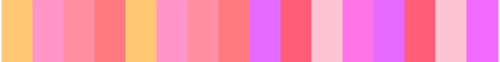

In [36]:
schub_ws = Wavescape(schub_fifth_utm, 500, drawing_primitive='hexagon')
schub_ws.draw_single_stripe(0, plot_delimiters=False)

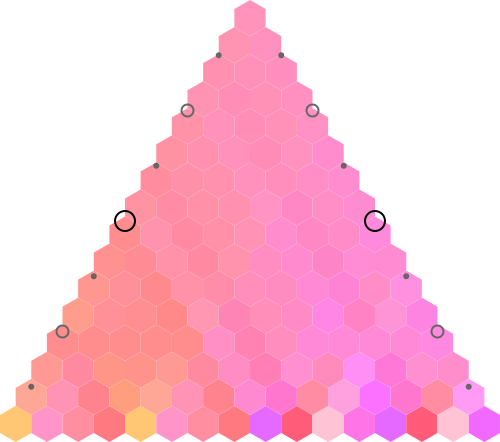

In [35]:
schub_ws.draw()

### Part Bonus: Hexagon formed by 6 wavescapes.

In [17]:
def generate_all_coeffs_image(dft_utm, resolution, plot_indicators=True):
    return {str(i): Wavescape(complex_utm_to_ws_utm(dft_utm, i, segmented_mode=False),\
                              resolution).draw(plot_indicators=plot_indicators, add_bg = False)\
            for i in range(1,7)}

def scaleImg(img):
    size_w = img.size[0]
    half_size_w = int(size_w/2.)
    size_h = img.size[1]
    #half_size_h = int(size_h/2.)
    canvas = Image.new('RGBA', (size_w*2, size_h*2), (0xff, 0xff,0xff, 0x00))
    #third argument of paste if the mask. In our case we use the image again as a mask, for not having the backgroun being drawn in white. 
    canvas.paste(img, (half_size_w, size_h), img)
    return canvas

def build_super_hexagon_pitcure(coeff_img_dict):
    prev_img = None
    temp_dir = tempfile.TemporaryDirectory()
    for i in range(1,7):
        coeff = str(i)
        curr_ws = coeff_img_dict[coeff]
        save_filename = temp_dir.name+'tmpWs'+coeff+'.png'
        curr_ws.savePng(save_filename)
        #60*(i+1) so that the first coeff. wavescape starts in
        curr_img = scaleImg(Image.open(save_filename).convert('RGBA')).rotate(60*(i+1))
        if prev_img:
            prev_img.paste(curr_img, (0,0), curr_img)
            del curr_img
        else:
            prev_img = curr_img
    return prev_img


#### Part Bonus Test: Bach's Prelude

In [ ]:
bach_pc_mat = produce_pitch_class_matrix_from_filename(bach_prelude_midi)
bach_fourier_utm = apply_dft_to_pitch_class_matrix(bach_pc_mat, build_utm = True)
res = build_super_hexagon_pitcure(generate_all_coeffs_image(bach_fourier_utm, 1500))
res